In [1]:
import geopandas as gpd
import os
import xarray as xr
import numpy as np
import pandas as pd
import copy
import pickle
import gc
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import leafmap


/opt/conda/envs/eurac_env/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_245807/2381691767.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

In [3]:
data_dir = '/mnt/CEPH_PROJECTS/sao/openEO_Platform'

In [4]:
big_pv_geoms = gpd.read_file(f"{data_dir}/germany_photovoltaic.shp")

In [5]:
# Filter the data to have farms bigger then 5 km2
big_pv_geoms_32632 = big_pv_geoms.to_crs(32632)
big_pv_geoms_32632_buffer_20 = copy.deepcopy(big_pv_geoms_32632)
big_pv_geoms_32632_buffer_20["geometry"] = [i.buffer(20) for i in big_pv_geoms_32632_buffer_20.geometry]
big_pv_geoms_buffer = big_pv_geoms_32632_buffer_20.to_crs(4326)


print(f"Number of selected PV Farms: {len(big_pv_geoms_buffer)}")

Number of selected PV Farms: 4458


In [6]:
bands = ['B01','B02','B03','B04',
         'B05','B06','B07','B08',
         'B8A', 'B11', 'B12']

### Extract the data and save them as numpy arrays
Run this section just for the first time

In [5]:
for i, geom in big_pv_geoms_buffer.iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
        
        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        #data_filled['crs'] = data.crs
        data.rio.write_crs("epsg:32633", inplace=True) #32633

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)

        ## Clip the farm polygon
        clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        break        
    except:
         print(f"This polygon id: {i} is not exist.")

This polygon id: 0 is not exist.
This polygon id: 1 is not exist.


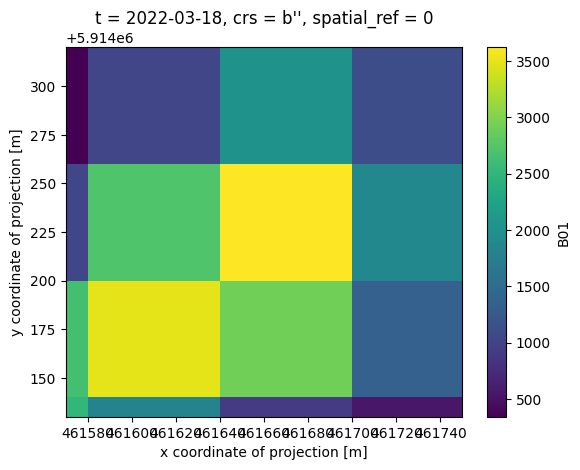

In [6]:
data['B01'][30].plot()

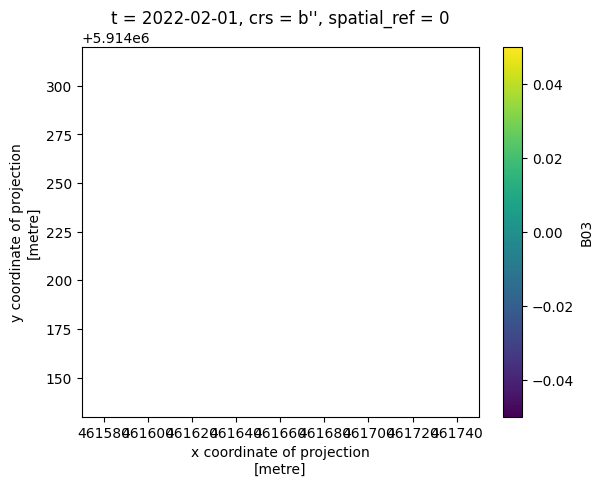

In [8]:
clipped['B03'][12].plot()

In [ ]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[280:].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
              
        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 280 is not exist.
This polygon id: 282 is not exist.
This polygon id: 284 is not exist.
This polygon id: 287 is not exist.
This polygon id: 288 is not exist.
This polygon id: 294 is not exist.
This polygon id: 307 is not exist.
This polygon id: 308 is not exist.
This polygon id: 315 is not exist.
This polygon id: 328 is not exist.
This polygon id: 342 is not exist.
This polygon id: 344 is not exist.
This polygon id: 348 is not exist.
This polygon id: 350 is not exist.
This polygon id: 351 is not exist.
This polygon id: 353 is not exist.
This polygon id: 356 is not exist.
This polygon id: 365 is not exist.
This polygon id: 375 is not exist.
This polygon id: 376 is not exist.
This polygon id: 377 is not exist.
This polygon id: 386 is not exist.
This polygon id: 390 is not exist.
This polygon id: 400 is not exist.
This polygon id: 403 is not exist.
This polygon id: 414 is not exist.
This polygon id: 422 is not exist.
This polygon id: 424 is not exist.
This polygon id: 425

In [ ]:
pv_samples = np.vstack(all_pixels_ts)
pv_samples.shape

In [ ]:
y1 = np.ones(pv_samples.shape[0])

In [24]:
print(pv_samples.shape)
print(y1.shape)

(490597, 11, 365)
(490597,)


In [25]:
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/pv_samples.npy', pv_samples)

In [9]:
# Extract S2 data for the photvoltaic farms - pixels outside the polygons "labels as 0"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[280:1500].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633

        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=True)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 280 is not exist.
This polygon id: 282 is not exist.
This polygon id: 284 is not exist.
This polygon id: 287 is not exist.
This polygon id: 288 is not exist.
This polygon id: 294 is not exist.
This polygon id: 307 is not exist.
This polygon id: 308 is not exist.
This polygon id: 315 is not exist.
This polygon id: 328 is not exist.
This polygon id: 342 is not exist.
This polygon id: 344 is not exist.
This polygon id: 348 is not exist.
This polygon id: 350 is not exist.
This polygon id: 351 is not exist.
This polygon id: 353 is not exist.
This polygon id: 356 is not exist.
This polygon id: 365 is not exist.
This polygon id: 375 is not exist.
This polygon id: 376 is not exist.
This polygon id: 377 is not exist.
This polygon id: 386 is not exist.
This polygon id: 390 is not exist.
This polygon id: 400 is not exist.
This polygon id: 403 is not exist.
This polygon id: 414 is not exist.
This polygon id: 422 is not exist.
This polygon id: 424 is not exist.
This polygon id: 425

In [ ]:
non_pv_samples = np.vstack(all_pixels_ts)
non_pv_samples.shape

In [ ]:
y0 = np.zeros(non_pv_samples.shape[0])

In [ ]:
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/non_pv_samples.npy', non_pv_samples)

#### Combine both PV and Non-PV togehter 

In [10]:
non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/non_pv_samples.npy')
pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/pv_samples.npy')

In [11]:
y1 = np.zeros(pv_samples.shape[0])
y0 = np.zeros(non_pv_samples.shape[0])

In [12]:
print(pv_samples.shape)
print(non_pv_samples.shape)

print(y1.shape)
print(y0.shape)

(490597, 11, 365)
(320803, 11, 365)
(490597,)
(320803,)


In [13]:
tr_data = np.vstack([pv_samples, non_pv_samples])
y = np.hstack([y1, y0])

In [14]:
print(tr_data.shape)
print(y.shape)

(498597, 11, 365)
(498597,)


### Modeling

In [8]:
non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/non_pv_samples.npy')
pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/pv_samples.npy')

y1 = np.ones(pv_samples.shape[0])
y0 = np.zeros(non_pv_samples.shape[0])

tr_data = np.vstack([pv_samples, non_pv_samples])
y = np.hstack([y1, y0])

In [9]:
del non_pv_samples, pv_samples, y1, y0 ; gc.collect()

496

In [10]:
tr_data = np.nan_to_num(tr_data, nan=-999999)

In [11]:
tr_data = tr_data.reshape(tr_data.shape[0], tr_data.shape[1]*tr_data.shape[2])
tr_data.shape

(811400, 4015)

In [ ]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=2024) # for cross validation

# Creating loop for the stratified k fold
scores = []
i = 0
for train, val in skf.split(tr_data, y):
    print(f'########### Fold number {i+1} ')

    # spliting the data
    x_train, x_val = tr_data[train], tr_data[val]
    y_train, y_val = y[train], y[val]
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=2024)
    clf.fit(x_train, y_train)
    
    
    # Validation
    y_pred = clf.predict(x_val)
    score = accuracy_score(y_pred, y_val)
    scores.append(score)
    print(f'Accuracy Score: {score}')
    
    filename = f'../models/non_temporal_models/rf_non_temporal_{i+1}.sav'
    pickle.dump(clf, open(filename, 'wb'))
    
    i+=1
    break
print(f'Average F1 Score: {np.mean(scores)}')

########### Fold number 1 


In [13]:
print(f'Average F1 Score: {np.mean(scores)}')

Average F1 Score: 0.8558232684249445


In [ ]:
del tr_data, x_train, x_val, y_train, y_val; gc.collect()

### Inference  

#### Extrac the dataset 
Run it for the first time

In [27]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[:280].iterrows(): #280
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
              
        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')
        
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1)) 
        #break
    
    except:
        print(f"This polygon id: {i} is not exist.")


This polygon id: 0 is not exist.
This polygon id: 1 is not exist.
This polygon id: 6 is not exist.
This polygon id: 9 is not exist.
This polygon id: 17 is not exist.
This polygon id: 27 is not exist.
This polygon id: 29 is not exist.
This polygon id: 56 is not exist.
This polygon id: 62 is not exist.
This polygon id: 65 is not exist.
This polygon id: 69 is not exist.
This polygon id: 74 is not exist.
This polygon id: 84 is not exist.
This polygon id: 87 is not exist.
This polygon id: 97 is not exist.
This polygon id: 99 is not exist.
This polygon id: 103 is not exist.
This polygon id: 107 is not exist.
This polygon id: 118 is not exist.
This polygon id: 124 is not exist.
This polygon id: 130 is not exist.
This polygon id: 138 is not exist.
This polygon id: 140 is not exist.
This polygon id: 143 is not exist.
This polygon id: 170 is not exist.
This polygon id: 171 is not exist.
This polygon id: 177 is not exist.
This polygon id: 184 is not exist.
This polygon id: 186 is not exist.
This 

In [30]:
te_pv_samples = np.vstack(all_pixels_ts)
te_pv_samples = np.nan_to_num(te_pv_samples, nan=-999999)

In [31]:
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/te_pv_samples.npy', te_pv_samples)

In [32]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[:280].iterrows(): #280
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
              
        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')
        
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=True)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1)) 
        #break
    
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 0 is not exist.
This polygon id: 1 is not exist.
This polygon id: 6 is not exist.
This polygon id: 9 is not exist.
This polygon id: 17 is not exist.
This polygon id: 27 is not exist.
This polygon id: 29 is not exist.
This polygon id: 56 is not exist.
This polygon id: 62 is not exist.
This polygon id: 65 is not exist.
This polygon id: 69 is not exist.
This polygon id: 74 is not exist.
This polygon id: 84 is not exist.
This polygon id: 87 is not exist.
This polygon id: 97 is not exist.
This polygon id: 99 is not exist.
This polygon id: 103 is not exist.
This polygon id: 107 is not exist.
This polygon id: 118 is not exist.
This polygon id: 124 is not exist.
This polygon id: 130 is not exist.
This polygon id: 138 is not exist.
This polygon id: 140 is not exist.
This polygon id: 143 is not exist.
This polygon id: 170 is not exist.
This polygon id: 171 is not exist.
This polygon id: 177 is not exist.
This polygon id: 184 is not exist.
This polygon id: 186 is not exist.
This 

In [33]:
te_non_pv_samples = np.vstack(all_pixels_ts)
te_non_pv_samples = np.nan_to_num(te_non_pv_samples, nan=-999999)
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/te_non_pv_samples.npy', te_non_pv_samples)

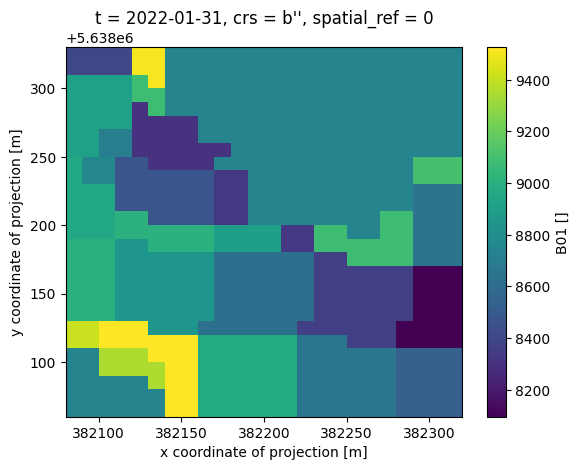

In [18]:
ds_daily_interp['B01'][30].plot()

In [19]:
## Clip the farm polygon - We do not crop it here cuz we need to classifiy all the pixels 
clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

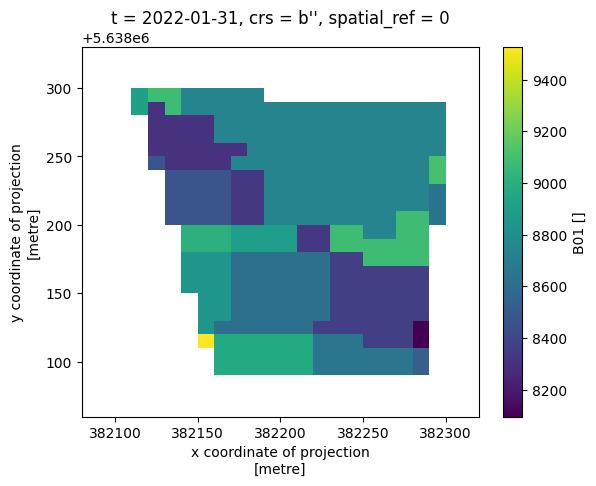

In [20]:
clipped['B01'][30].plot()

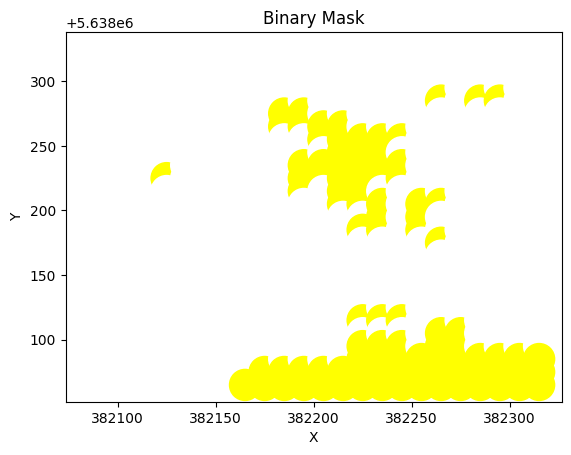

In [26]:
custom_cmap = ListedColormap(['white', 'yellow']) #yellow for 1 and white for 0

# Plot the binary mask
plt.scatter(x, y, c=te_pred, cmap=custom_cmap, s=500)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Binary Mask')
plt.show()

#### Inference

In [6]:
te_non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/te_non_pv_samples.npy')
te_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/te_pv_samples.npy')

y1 = np.ones(te_pv_samples.shape[0])
y0 = np.zeros(te_non_pv_samples.shape[0])

In [7]:
te_data = np.vstack([te_pv_samples, te_non_pv_samples])
y_test = np.hstack([y1, y0])

In [8]:
te_samples = te_data.reshape(te_data.shape[0], te_data.shape[1]*te_data.shape[2])
te_samples.shape

(380403, 4015)

In [9]:
clf = pickle.load(open(f'../models/non_temporal_models/rf_non_temporal_1.sav', 'rb'))

In [10]:
te_pred = clf.predict(te_samples)

In [13]:
test_score = accuracy_score(te_pred, y_test)
print(f'Test Accuracy Score: {test_score}')

Test Accuracy Score: 0.7340399523663063


In [16]:
te_pv_samples = te_pv_samples.reshape(te_pv_samples.shape[0], te_pv_samples.shape[1]*te_pv_samples.shape[2])


te_pred = clf.predict(te_pv_samples)

test_score = accuracy_score(te_pred, y1)
print(f'Test Accuracy Score for PV pixels: {test_score}')

Test Accuracy Score for PV pixels: 0.8237583892617449


#### This is for plotting

In [24]:
df_normal = df.reset_index()
x = df_normal[['x', 'y']].values[:,0]
y = df_normal[['x', 'y']].values[:,1]

In [25]:
te_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Leaf map

In [10]:
# Enter the farm id in the GDF
farm = 278

In [11]:
# Extract data for any farm 

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[farm : farm+1].iterrows(): #280
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
              
        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')
        
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1)) 
        #break
    
    except:
        print(f"This polygon id: {i} is not exist.")

In [21]:
geom_wgs84 = big_pv_geoms_buffer.iloc[278]
centroid = geom_wgs84.geometry.centroid


In [24]:
m = leafmap.Map(center=[centroid.y, centroid.x], zoom=17,basemap="Esri.WorldImagery") #ROADMAP Esri.WorldImagery
m

Map(center=[47.845427660708246, 12.756228375361003], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [7]:
import pickle
clf = pickle.load(open(f'../models/non_temporal_models/rf_non_temporal_1.sav', 'rb'))

ValueError: node array from the pickle has an incompatible dtype:
- expected: [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]
- got     : {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}

In [36]:
arr_ts= []
for b in bands:
    df_b = df[b]
    df_b = df_b.dropna(how = 'all')
    arr_ts.append(np.array(df_b))

all_pixels_ts.append(np.stack(arr_ts, axis=1)) 

In [37]:
all_pixels_ts

[array([], shape=(0, 11, 365), dtype=float32),
 array([], shape=(0, 11, 365), dtype=float32)]

In [29]:
data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
data

<xarray.Dataset>
Dimensions:  (t: 143, x: 52, y: 84)
Coordinates:
  * t        (t) datetime64[ns] 2022-01-01 2022-01-03 ... 2022-12-27 2022-12-29
  * x        (x) float64 7.071e+05 7.071e+05 7.071e+05 ... 7.076e+05 7.076e+05
  * y        (y) float64 5.682e+06 5.682e+06 5.682e+06 ... 5.681e+06 5.681e+06
    crs      |S1 ...
Data variables: (12/13)
    B01      (t, y, x) float32 ...
    B02      (t, y, x) float32 ...
    B03      (t, y, x) float32 ...
    B04      (t, y, x) float32 ...
    B05      (t, y, x) float32 ...
    B06      (t, y, x) float32 ...
    ...       ...
    B08      (t, y, x) float32 ...
    B8A      (t, y, x) float32 ...
    B09      (t, y, x) float32 ...
    B11      (t, y, x) float32 ...
    B12      (t, y, x) float32 ...
    SCL      (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

In [30]:
cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
data = data.where(~cloud_mask)  

## This step to fill the gaps (nan values) spatially
data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
data.rio.write_crs("epsg:32633", inplace=True) #32633

<xarray.Dataset>
Dimensions:      (t: 143, y: 84, x: 52)
Coordinates:
  * t            (t) datetime64[ns] 2022-01-01 2022-01-03 ... 2022-12-29
  * x            (x) float64 7.071e+05 7.071e+05 ... 7.076e+05 7.076e+05
  * y            (y) float64 5.682e+06 5.682e+06 ... 5.681e+06 5.681e+06
    crs          |S1 b''
    spatial_ref  int64 0
Data variables: (12/13)
    B01          (t, y, x) float32 nan nan nan nan ... 893.0 893.0 893.0 893.0
    B02          (t, y, x) float32 nan nan nan nan ... 977.0 1.092e+03 1.174e+03
    B03          (t, y, x) float32 nan nan nan nan ... 678.0 769.0 795.0 872.0
    B04          (t, y, x) float32 nan nan nan nan ... 570.0 580.0 551.0 554.0
    B05          (t, y, x) float32 nan nan nan nan ... 636.0 636.0 591.0 591.0
    B06          (t, y, x) float32 nan nan nan nan ... 756.0 756.0 750.0 750.0
    ...           ...
    B08          (t, y, x) float32 nan nan nan nan ... 954.0 971.0 1.038e+03
    B8A          (t, y, x) float32 nan nan nan nan ... 816.0 816.0 797.0 797.0
    B09          (t, y, x) float32 nan nan nan nan ... 991.0 991.0 991.0 991.0
    B11          (t, y, x) float32 nan nan nan nan ... 466.0 466.0 476.0 476.0
    B12          (t, y, x) float32 nan nan nan nan ... 425.0 425.0 404.0 404.0
    SCL          (t, y, x) float32 nan nan nan nan nan ... 3.0 3.0 3.0 3.0 3.0
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

In [31]:
## Linear interpolation to have full time-series
daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                 end=pd.to_datetime(end_date),
                                 freq='D')

ds_daily = data.reindex(t=daily_date_range)
ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

In [32]:
clipped

<xarray.Dataset>
Dimensions:      (t: 365, x: 52, y: 84)
Coordinates:
  * t            (t) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31
  * x            (x) float64 7.071e+05 7.071e+05 ... 7.076e+05 7.076e+05
  * y            (y) float64 5.682e+06 5.682e+06 ... 5.681e+06 5.681e+06
    crs          |S1 b''
    spatial_ref  int64 0
Data variables: (12/13)
    B01          (t, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    B02          (t, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    B03          (t, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    B04          (t, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    B05          (t, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    B06          (t, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    ...           ...
    B08          (t, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    B8A          (t, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    B09          (t, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    B11          (t, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    B12          (t, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    SCL          (t, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform